# PyMC and Universal Samplers

## Part A: `import pymc`

In [1]:
import pymc

- [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html)
- [Example Gallary](https://www.pymc.io/projects/examples/en/latest/gallery.html)

In [ ]:
print(f"Running on PyMC v{pymc.__version__}")

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
n = 100
true_theta, true_tau = 0,1
data_generating_mechanism = \
stats.norm(loc=true_theta, scale=true_tau**(-0.5))

x = data_generating_mechanism.rvs(size=n)
plt.hist(x, density=True)
x_grid = np.linspace(-5*true_tau**(-0.5),5*true_tau**(-0.5),1000)
plt.plot(x_grid,data_generating_mechanism.pdf(x_grid));


In [ ]:
conjugate_normal_gamma = pymc.Model()

with conjugate_normal_gamma:

    # Priors for unknown model parameters

    theta0 = 0  # prior belief regarding true_theta
    theta_prior_n = 1  # strength of prior belief as units of data
    # theta_prior_n = tau0/true_tau
    tau0 = theta_prior_n*true_tau
    theta = pymc.Normal("theta", mu=theta0, sigma=tau0**(-0.5))
    # Compared to scipy.stats
    # loc -> mu
    # scale -> sigma but you can also use tau as below...

    tau_SS_prior = 1  # prior belief regarding true_sum_of_squares
    tau_prior_n = 1  # strength of prior belief as units of data
    tau = pymc.Gamma("tau", alpha=tau_prior_n/2,
                            beta=tau_SS_prior/2)
    # https://en.wikipedia.org/wiki/Gamma_distribution
    # pymc.Gamma?
    # Now it's **rate** (beta) NOT scale

    # Likelihood (sampling distribution) of observations
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)

In [ ]:
pymc.model_to_graphviz(conjugate_normal_gamma)

In [ ]:
m = 10000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

## `idata` and `arviz as az`

In [ ]:
idata

In [ ]:
idata.posterior

In [ ]:
idata.posterior['theta']

In [ ]:
idata.posterior['tau']

In [ ]:
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3));ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

In [ ]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

In [ ]:
import arviz as az

In [ ]:
idata

In [ ]:
az.plot_trace(idata, combined=True);

In [ ]:
az.plot_trace(idata)
plt.tight_layout()

In [ ]:
m = 1000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

In [ ]:
# If the messages below don't show
"""Auto-assigning NUTS sampler...
   Initializing NUTS using jitter+adapt_diag...
   Multiprocess sampling (2 chains in 4 jobs)
   NUTS: [theta, tau] """
# You can see this information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

In [ ]:
az.plot_forest(idata, var_names=["theta", "tau"],
               combined=False, hdi_prob=0.95, r_hat=True);


## Part B: Posterior inference and diagnostics<br><sub>with `az.summary`</sub>

In [ ]:
az.summary(idata, round_to=5)#2)

In [ ]:
theta.ravel().shape

### `mean` and `sd`

In [ ]:
round_to=5
theta.ravel().mean().round(round_to), tau.ravel().mean().round(round_to)

In [ ]:
theta.ravel().std().round(round_to), tau.ravel().std().round(round_to)
theta.ravel().std(ddof=1).round(round_to), tau.ravel().std(ddof=1).round(round_to)

### `hdi_3%` and `hdi_97%`

In [ ]:
az.summary(idata, round_to=5)#2)

In [ ]:
np.quantile(theta,[0.05,0.95]).round(round_to)

In [ ]:
np.quantile(theta,[0.025,0.975]).round(round_to)

In [ ]:
np.quantile(theta,[0.03,0.97]).round(round_to)

In [ ]:
# hdi_3% and hdi_97% is something like
# move interval up or down until the smallest interval is found
np.quantile(theta,[0.02,0.96]).round(round_to)

In [ ]:
# so trying to get a bit closer for tau it's someting like
np.quantile(tau,[0.022,0.9622]).round(round_to)

### To consider `mcse_mean` and `mcse_sd`...

- [...moments of moments and first order Taylor series approximation](https://mc-stan.org/posterior/reference/mcse_sd.html)

In [ ]:
az.summary(idata, round_to=5)

In [ ]:
az.summary(idata, round_to=5)['sd']['theta']/\
az.summary(idata, round_to=5)['ess_bulk']['theta']**0.5

In [ ]:
az.summary(idata, round_to=5)['sd']['tau']/\
(az.summary(idata, round_to=5)['ess_bulk']['tau']+0)**0.5

In [ ]:
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']


In [ ]:
# this estimates y which is the variance
((theta.ravel()-theta.ravel().mean())**2).mean()
theta.ravel().var()
# square root of this estimates standard deviation
# s = sqrt(y)

# this estimates variance of y above estimator
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']

# by the delta method
# https://stats.stackexchange.com/questions/491845/how-is-delta-method-used-here-in-approximating-the-square-root-of-a-normal-rando
# var(S) = (1/sqrt(E[Y]))**2 * Var(Y)

((1/theta.ravel().var())*\
 ((theta.ravel()-theta.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['theta'])**0.5

# So it's not quite right...but then again it's maybe not exactly
# https://mc-stan.org/posterior/reference/mcse_sd.html
# "Compute the Monte Carlo standard error for the
#  standard deviation (SD) of a single variable
#  without assuming normality using moments of moments
#  and first order Taylor series approximation
#  (Kenney and Keeping, 1951, p. 141)."

In [ ]:
((1/tau.ravel().var())*\
 ((tau.ravel()-tau.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['tau'])**0.5

In [ ]:
az.summary(idata, round_to=5)

### We must first consider `bulk_tail` and `ess_tail`...

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [ ]:
theta_in_tail = \
(theta<=np.quantile(theta.ravel(),0.05))#+\
(theta>=np.quantile(theta.ravel(),0.95))
print(theta_in_tail.sum()/(2*m))
theta_in_tail

In [ ]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta_in_tail[c,:-t_plus_k],
                    theta_in_tail[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c))

# effective sample size
approximation_stops=[5,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [ ]:
autocorrelations[:,:10]

In [ ]:
tau_in_tail = \
(tau<=np.quantile(tau.ravel(),0.05))+\
(tau>=np.quantile(tau.ravel(),0.95))
print(tau_in_tail.sum()/(2*m))
tau_in_tail

In [ ]:
m = 1000
K = 30
autocorrelations = np.ones((2,m-1))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau_in_tail[c,:-t_plus_k],
                    tau_in_tail[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c))

# effective sample size
approximation_stops=[8,6]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())

In [ ]:
autocorrelations[:,:20]

In [ ]:
az.summary(idata, round_to=5)

#### Reminder

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [ ]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta[c,:-t_plus_k],
                    theta[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c))

# effective sample size
approximation_stops=[3,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [ ]:
autocorrelations[:,:10]

In [ ]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau[c,:-t_plus_k],
                    tau[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c))

# effective sample size
approximation_stops=[5,7]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [ ]:
autocorrelations[:,:10]

In [ ]:
az.summary(idata, round_to=5)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(theta.ravel()[:-1], theta.ravel()[1:], '.', alpha=0.25)
ax[1].plot(tau.ravel()[:-1], tau.ravel()[1:], '.', alpha=0.25);

## Part C: R-hat and "energy"

A lack of insufficient "mixing" (agreement) between chains is diagnosed by comparing within and between chain variability. This is done by **checking if the split-$\hat R$ statistic is greater than** $\mathbf{1.05}$. is deemed sufficient when . This is suggestive (but not proof) that the the **Markov chains** have converged to their **stationary distributions**.

> Thus far above we have avoided the notion of "split" chains. Split chains must be considered to ensure that a "drifting chain" does not accidentally pass the $\hat R$ check. Thus the split-$\hat R$ statistic.


$\Large \text{Split-}\hat R  = \sqrt{\frac{\frac{N-1}{N}W +  \overbrace{\frac{1}{M-1}\sum_{m=1}^M (\overline{\theta^{(m,\cdot)}} - \overline{\theta^{(\cdot,\cdot)}})^2}^{\text{between chain variance}} }{\underbrace{\frac{1}{M}\sum_{m=1}^M \frac{1}{N-1}\sum_{n=1}^N (\theta^{(m,n)} - \overline{\theta^{(m,\cdot)}})^2}_{\text{$W$: within chain variance}}} } $

In [ ]:
az.summary(idata, round_to=5)

In [ ]:
az.plot_trace(idata)
plt.tight_layout()

### Energy

Another diagnostic that sometimes applies is based on the so-called [energy](https://discourse.mc-stan.org/t/help-understanding-bfmi-interpreting-bfmi-1/28554). The exact meaning of "energy" will be discussed next class but for now suffice it to say that when the "Energy transition" fails to dominate the "Marginal energy" the sampler is experiencing a computational bottleneck.


In [ ]:
az.plot_energy(idata);

## Part D: Samplers


In [ ]:
pymc.sample?

In [ ]:
with conjugate_normal_gamma:
    HMC = pymc.HamiltonianMC()
    idata_HMC = pymc.sample(chains=4, step=HMC)

display(az.summary(idata_HMC, round_to=2))
az.plot_trace(idata_HMC)
plt.tight_layout()

In [ ]:
# theta rejection rates
(idata_HMC.posterior.theta.values[:,:-1]==idata_HMC.posterior.theta.values[:,1:]).mean(axis=1)

In [ ]:
# tau rejection rates
(idata_HMC.posterior.tau.values[:,:-1]==idata_HMC.posterior.tau.values[:,1:]).mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_HMC.posterior.theta.values.ravel()[:-1],
           idata_HMC.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_HMC.posterior.tau.values.ravel()[:-1],
           idata_HMC.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

In [ ]:
with conjugate_normal_gamma:
    idata = pymc.sample(chains=4, target_accept=0.9)

display(az.summary(idata, round_to=2))
az.plot_trace(idata)
plt.tight_layout()

In [ ]:
import pandas as pd
display(pd.DataFrame(idata.sample_stats.acceptance_rate))
# rejection rates
1-idata.sample_stats.acceptance_rate.values.mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata.posterior.theta.values.ravel()[:-1],
           idata.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata.posterior.tau.values.ravel()[:-1],
           idata.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

In [ ]:
with conjugate_normal_gamma:
    sampler = pymc.Slice()
    idata_slice = pymc.sample(step=sampler)

display(az.summary(idata_slice, round_to=2))
az.plot_trace(idata_slice)
plt.tight_layout()

In [ ]:
# theta rejection rates
(idata_slice.posterior.theta.values[:,:-1]==idata_slice.posterior.theta.values[:,1:]).mean(axis=1)

In [ ]:
# tau rejection rates
(idata_slice.posterior.tau.values[:,:-1]==idata_slice.posterior.tau.values[:,1:]).mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_slice.posterior.theta.values.ravel()[:-1],
           idata_slice.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_slice.posterior.tau.values.ravel()[:-1],
           idata_slice.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

In [ ]:
with conjugate_normal_gamma:
    MHv1 = pymc.Metropolis(S=np.ones(1), scaling=1, tune=False)
    idata_MHv1 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv1)

display(az.summary(idata_MHv1, round_to=2))
az.plot_trace(idata_MHv1)
plt.tight_layout()

In [ ]:
# theta rejection rates
(idata_MHv1.posterior.theta.values[:,:-1]==idata_MHv1.posterior.theta.values[:,1:]).mean(axis=1)

In [ ]:
# tau rejection rates
(idata_MHv1.posterior.tau.values[:,:-1]==idata_MHv1.posterior.tau.values[:,1:]).mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv1.posterior.theta.values.ravel()[:-1],
           idata_MHv1.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv1.posterior.tau.values.ravel()[:-1],
           idata_MHv1.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

In [ ]:
with conjugate_normal_gamma:
    MHv2 = pymc.Metropolis(S=np.ones(1), scaling=0.1, tune=False)
    idata_MHv2 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv2)

display(az.summary(idata_MHv2, round_to=2))
az.plot_trace(idata_MHv2)
plt.tight_layout()

In [ ]:
# theta rejection rates
(idata_MHv2.posterior.theta.values[:,:-1]==idata_MHv2.posterior.theta.values[:,1:]).mean(axis=1)

In [ ]:
# tau rejection rates
(idata_MHv2.posterior.tau.values[:,:-1]==idata_MHv2.posterior.tau.values[:,1:]).mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv2.posterior.theta.values.ravel()[:-1],
           idata_MHv2.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv2.posterior.tau.values.ravel()[:-1],
           idata_MHv2.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

## Week 5 Homework

---

### Q1: Questions about PyMC...

Complete this formatted markdown listing of the contents of "PyMC Example Gallery". *Include links and your favorite image (right click and "copy image address") from each page.*


#### Introductory

- [General Overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)
- [Simple Linear Regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)
- [General API quickstart](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/ac30f30b2297ec4f2bb798b4f28d2cbba2d0502dbaae4a5f78fdd5cccacda517.svg)|<img src="https://www.pymc.io/projects/docs/en/stable/_images/a8276d1222c43c061dbfff6fa3ff3af15b86038fd7d1e204c429ae3714ea1a20.png"  width="500"/>|![](https://www.pymc.io/projects/examples/en/latest/_images/434538d8660bf2399ebf9df11cbd2b7cec62d8abafc588da625315074b628118.png)|

#### Library Fundamentals

- [Distribution Dimensionality](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/dimensionality.html)
- [PyMC and PyTensor](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_pytensor.html)
- [Using Data Containers](https://www.pymc.io/projects/examples/en/latest/fundamentals/data_container.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/acfb0536de4db53baddb8a6d632d6efdc65c01eedeee1a90b7b1e1dd45db4c16.svg)|![](https://raw.githubusercontent.com/pymc-devs/pytensor/main/doc/tutorial/apply.png)|![](https://www.pymc.io/projects/examples/en/latest/_images/90f5f05f83d677cb540fc16bcf5962b15949b9cf531848fe6b20c02a7e271e24.svg)|


#### Etc.

- 1.[A Primer on Bayesian Methods for Multilevel Modeling](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html)
- 2.[Out-Of-Sample Predictions](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-out-of-sample-predictions.html)
- 3.[Binomial regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-binomial-regression.html)
- 4.[GLM-missing-values-in-covariates](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-missing-values-in-covariates.html)
- 5.[Regression Models with Ordered Categorical Outcomes](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-ordinal-regression.html)
- 6.[Discrete Choice and Random Utility Models](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-discrete-choice_models.html)
- 7.[GLM: Robust Regression using Custom Likelihood for Outlier Classification](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-robust-with-outlier-detection.html)
- 8.[Simpson’s paradox](https://www.pymc.io/projects/examples/en/latest/causal_inference/GLM-simpsons-paradox.html)
- 9.[Interrupted time series analysis](https://www.pymc.io/projects/examples/en/latest/causal_inference/interrupted_time_series.html)
- 10.[Counterfactual inference: calculating excess deaths due to COVID-19](https://www.pymc.io/projects/examples/en/latest/causal_inference/excess_deaths.html)
- 11.[Introduction to Bayesian A/B Testing](https://www.pymc.io/projects/examples/en/latest/causal_inference/bayesian_ab_testing_introduction.html)
- 12.[Kronecker Structured Covariances](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Kron.html)
- 13.[Gaussian Processes: Latent Variable Implementation](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-Latent.html)

| | | | |
|-|-|-|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/8c391b5a5d0a466c41c1abaf5cf4ddb1278e268ba56361003f42b02b4684c181.svg)|![](https://www.pymc.io/projects/examples/en/latest/_images/300d0cf80648831ccb0009c099225a7540f30c1fc7e80e3cd24f2dcaf375f6bd.png)|![](https://www.pymc.io/projects/examples/en/latest/_images/416e190e3cba27b9495347b6b596b1c634994cf1b232c9b02da86c99b9e3d03c.svg)|![](https://www.pymc.io/projects/examples/en/latest/_images/985e3771701853b6c582c314da571199130d76599e4bdfa48dea7f1285ab550f.svg)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/bcfde70f4463aa317773d22138844a351017dcb759e243cbc046495501ac5e85.svg)|![](https://www.pymc.io/projects/examples/en/latest/_images/7f7dc6b81110881a888c14d6532de5f4e5993aad85e141bce5d3ebadfc75590b.svg)|![](https://www.pymc.io/projects/examples/en/latest/_images/5435a742fd4cdea7455782b3bd158803caad25eb5f7a500a7e6bc84ce1415e72.svg)|![](https://www.pymc.io/projects/examples/en/latest/_images/852847856bacd9b43ed0e5b47b52780a18b9d5cc4d52908995ce1a54b2a474f0.svg)|
|![](https://www.pymc.io/projects/examples/en/latest/_images/07d35f8ce735c0bef9e204ad7e609371f84bfdcf6b938a252845dc6e65ff3004.svg)|![](https://www.pymc.io/projects/examples/en/latest/_images/2e0c2c7923bb7e22a418e60653170b206d80f638c5937e50a180c45094f4f042.png)|![](https://www.pymc.io/projects/examples/en/latest/_images/05b1553c08b71229f5a0dbd8faf3041e01ccd3467e0c74d2745edeb447014f11.png)|![](https://www.pymc.io/projects/examples/en/latest/_images/f47ff99a7109188e15e5f39c15c8da84c90d147a307587f333bed35406ebe1f2.svg)|![]()|

| |
|-|
|![](https://www.pymc.io/projects/examples/en/latest/_images/39603df4f63e88e15dfca57f1eaf6f6aa6385cc08c9e8de8fce0ae99d7ae2162.png)|


### Q2: Continue "Q2" of the previous weeks 3 and 4

1. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a normal distribution and your prior for $\tau$ is a gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

2. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a non normal distribution and your prior for $\tau$ is a non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

3. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a yet another different again non normal distribution and your prior for $\tau$ is a yet another different again non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*



Output()

Output()

Model 1: Effective Sample Size
<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    tau      float64 8B 3.955e+03
    theta    float64 8B 3.18e+03


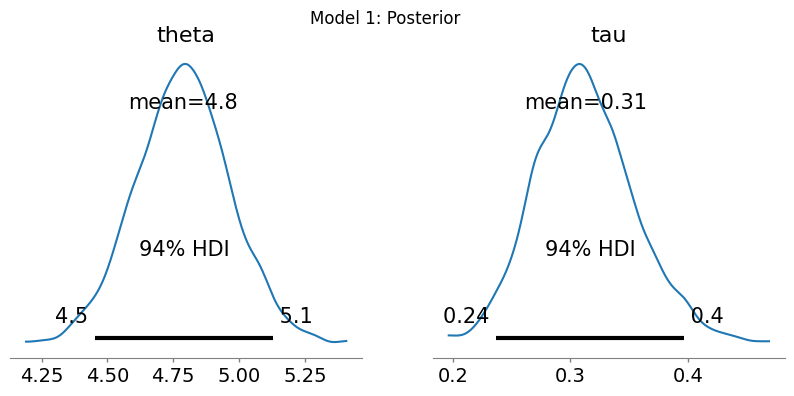

In [6]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Generate observed data
np.random.seed(42)
data = np.random.normal(loc=5, scale=2, size=100)

# PyMC Model 1
with pm.Model() as model1:
    theta = pm.Normal("theta", mu=0, sigma=10)  # Normal prior
    tau = pm.Gamma("tau", alpha=2, beta=1)  # Gamma prior
    y_obs = pm.Normal("y_obs", mu=theta, sigma=1/pm.math.sqrt(tau), observed=data)  # Likelihood model
    trace1 = pm.sample(2000, return_inferencedata=True)  # Sampling

# Compute diagnostics
print("Model 1: Effective Sample Size")
print(az.ess(trace1))

# Plot posterior distributions
az.plot_posterior(trace1, var_names=["theta", "tau"], figsize=(10, 4))
plt.suptitle("Model 1: Posterior")
plt.show()


Output()

Output()

Model 2: Effective Sample Size
<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    tau      float64 8B 3.56e+03
    theta    float64 8B 3.975e+03


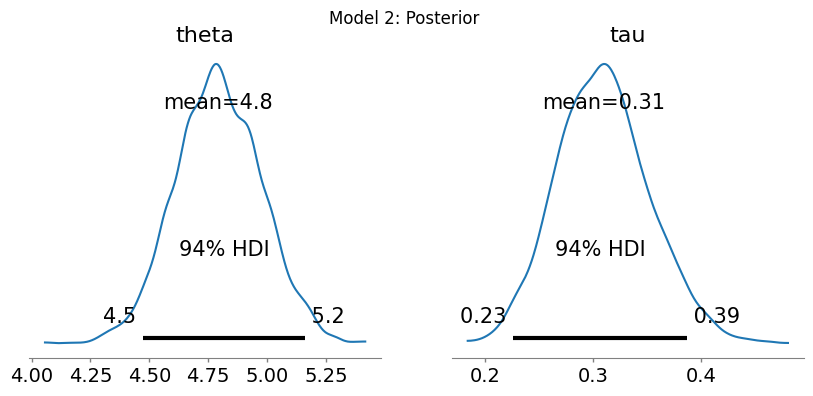

In [7]:
# PyMC Model 2
with pm.Model() as model2:
    theta = pm.StudentT("theta", nu=3, mu=0, sigma=10)  # Student-T prior
    tau = pm.HalfNormal("tau", sigma=1)  # Half-Normal prior
    y_obs = pm.Normal("y_obs", mu=theta, sigma=1/pm.math.sqrt(tau), observed=data)  # Likelihood model
    trace2 = pm.sample(2000, return_inferencedata=True)  # Sampling

# Compute diagnostics
print("Model 2: Effective Sample Size")
print(az.ess(trace2))

# Plot posterior distributions
az.plot_posterior(trace2, var_names=["theta", "tau"], figsize=(10, 4))
plt.suptitle("Model 2: Posterior")
plt.show()


Output()

Output()

Model 3: Effective Sample Size
<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    tau      float64 8B 3.962e+03
    theta    float64 8B 4.201e+03


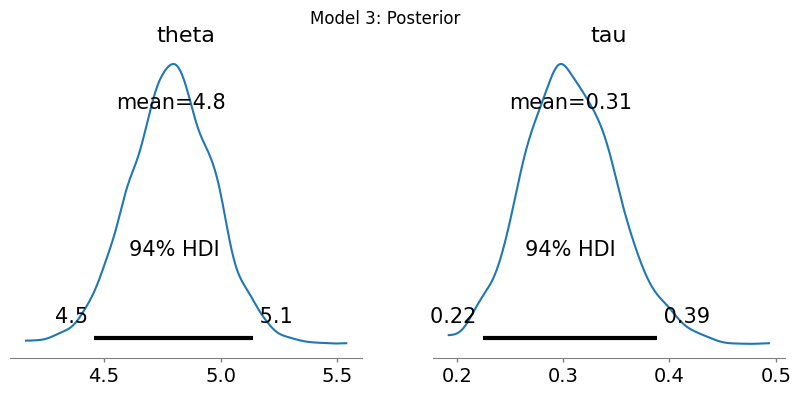

In [8]:
# PyMC Model 3
with pm.Model() as model3:
    theta = pm.Laplace("theta", mu=0, b=10)  # Laplace prior
    tau = pm.Exponential("tau", lam=1)  # Exponential prior
    y_obs = pm.Normal("y_obs", mu=theta, sigma=1/pm.math.sqrt(tau), observed=data)  # Likelihood model
    trace3 = pm.sample(2000, return_inferencedata=True)  # Sampling

# Compute diagnostics
print("Model 3: Effective Sample Size")
print(az.ess(trace3))

# Plot posterior distributions
az.plot_posterior(trace3, var_names=["theta", "tau"], figsize=(10, 4))
plt.suptitle("Model 3: Posterior")
plt.show()


### Q3: Slice Sampling

*First explain how the Markov algorithm of slice sampling as given below works. Then explain the steps by which slice sampling could be used in place of a Metropolis-Hasting step in a Metropolis within Gibbs algorithm where the full conditionals are only known up to a normalizing constant. In your explanation clarify what the curve that we're sampling beneath is, and what the initial value and steps are to create the draw for Gibbs sampling.*

### Explanation of the Slice Sampling Algorithm

Slice sampling is a Markov Chain Monte Carlo (MCMC) method used for sampling from an arbitrary distribution. It works as follows:

1. **Define the target distribution** $f(x)$, from which we want to sample.
2. **Choose an initial value** $x_0$.
3. **Draw a horizontal slice** by:
   - Sampling a vertical threshold $y \sim \text{Uniform}(0, f(x_0))$.
   - This creates a "slice" where $f(x) > y$.
4. **Find an interval** $[a, b]$ containing $x_0$ where $f(x) > y$.
5. **Sample a new** $x$ uniformly from the interval $[a, b]$.
6. **Repeat** the process to generate samples.

This method allows efficient sampling, even when the normalization constant of $f(x)$ is unknown.

### Using Slice Sampling in Metropolis-within-Gibbs

In **Metropolis-within-Gibbs**, slice sampling can replace the **Metropolis-Hastings step** when:

- The **full conditionals** are known **only up to a normalizing constant**.
- Instead of proposing a new value and accepting/rejecting, slice sampling **directly samples from the conditional distribution**.

### Steps to integrate slice sampling into Gibbs Sampling:

1. For each variable $X_i$, **slice sample** from $P(X_i | X_{-i})$ instead of using Metropolis-Hastings.
2. The remaining steps of Gibbs Sampling remain unchanged.
3. This reduces the rejection rate compared to Metropolis-Hastings.


In [ ]:
def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):

    # find interval of grid points where f(x_grid) > y
    # then extend the enterval so endpoints f(a)<y and f(b)<y
    x_grid_delta = x_grid[1]-x_grid[0]
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid

    x_ = a + stats.uniform().rvs()*(b-a)
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f"
    elif x_ < x:  # or if "x_ was above f on the left side of the interval"
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):

    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)

    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


In [ ]:
x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))

m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):

    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')

    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')

plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();